# Double Jet

With various grid sizes

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import copy
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

In [6]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=256, nx=512)
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

## Truth

In [7]:
from gpuocean.utils import Observation, DrifterPlotHelper

In [8]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-09-15T15_08_08"

true_trajectories = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

true_trajectories.read_pickle(os.path.join(truth_path, "truth_trajectories.pickle"))

In [9]:
true_trajectories.get_num_drifters()

100

## Ensemble drifter

In [10]:
slda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/SLDA/2023-09-20T09_04_01L8"

slda_drifter_path = os.path.join(slda_path, "sldrifters")

slda_trajectories = []
for f in os.listdir(slda_drifter_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(slda_drifter_path,f))
    
    slda_trajectories.append(trajectory)

In [11]:
slda2_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/SLDA/2023-09-20T10_27_40L7"

slda2_drifter_path = os.path.join(slda2_path, "sldrifters")

slda2_trajectories = []
for f in os.listdir(slda2_drifter_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(slda2_drifter_path,f))
    
    slda2_trajectories.append(trajectory)

In [12]:
slda3_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/SLDA/2023-09-20T11_23_28L6"

slda3_drifter_path = os.path.join(slda3_path, "sldrifters")

slda3_trajectories = []
for f in os.listdir(slda3_drifter_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(slda3_drifter_path,f))
    
    slda3_trajectories.append(trajectory)

In [13]:
mlda_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/MLDA/2023-09-19T14_10_37ls87"

mlda_drifter_path = os.path.join(mlda_path, "mldrifters")

mlda_trajectories = []
for f in os.listdir(mlda_drifter_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(mlda_drifter_path,f))
    
    mlda_trajectories.append(trajectory)

In [14]:
mlda2_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/MLDA/2023-09-20T16_53_50ls876"

mlda2_drifter_path = os.path.join(mlda2_path, "mldrifters")

mlda2_trajectories = []
for f in os.listdir(mlda_drifter_path):
    trajectory = Observation.Observation(domain_size_x=doubleJetCase_args["nx"]*doubleJetCase_args["dx"],
                                            domain_size_y=doubleJetCase_args["ny"]*doubleJetCase_args["dy"], 
                                            nx=doubleJetCase_args["nx"], ny=doubleJetCase_args["ny"])

    trajectory.read_pickle(os.path.join(mlda2_drifter_path,f))
    
    mlda2_trajectories.append(trajectory)

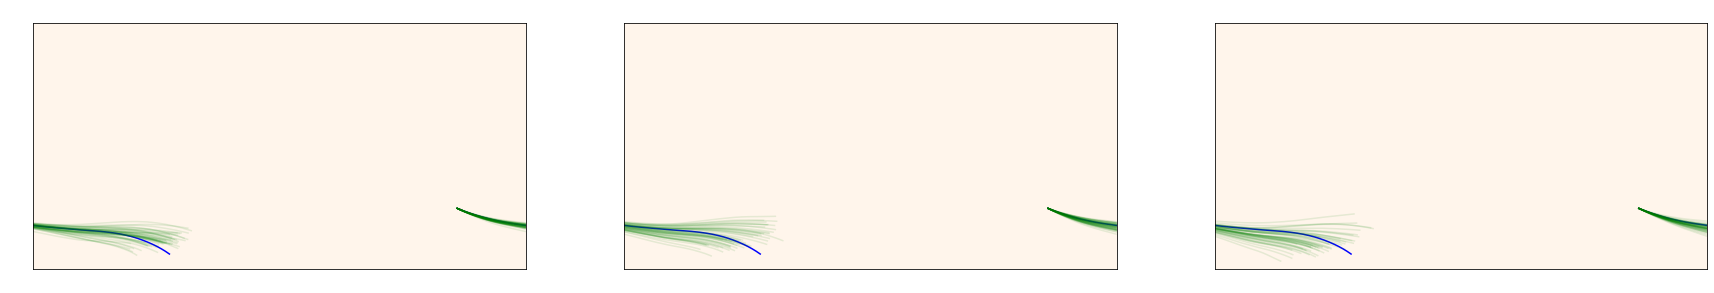

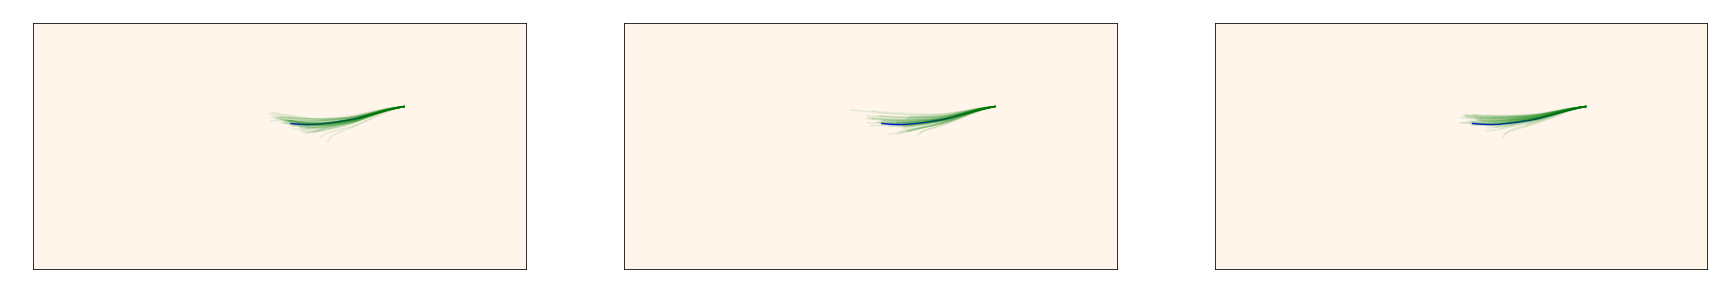

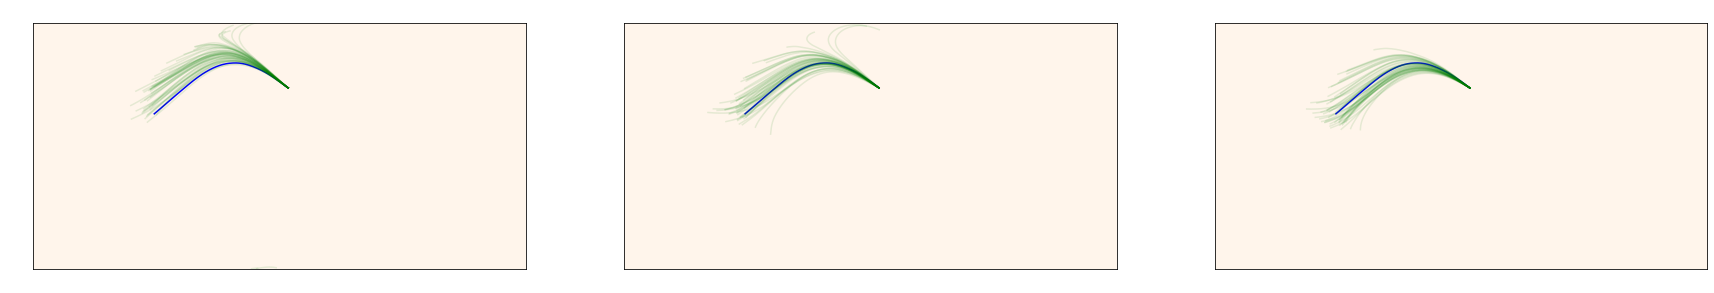

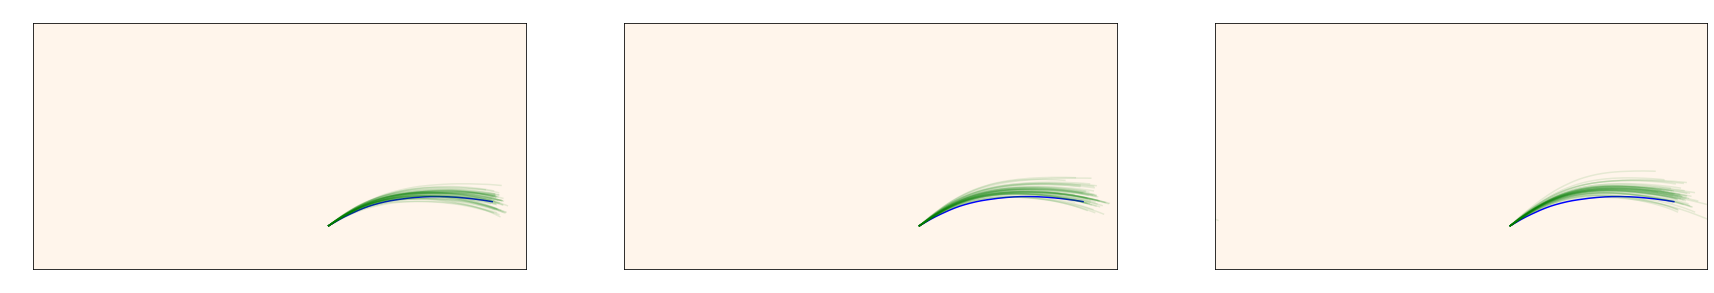

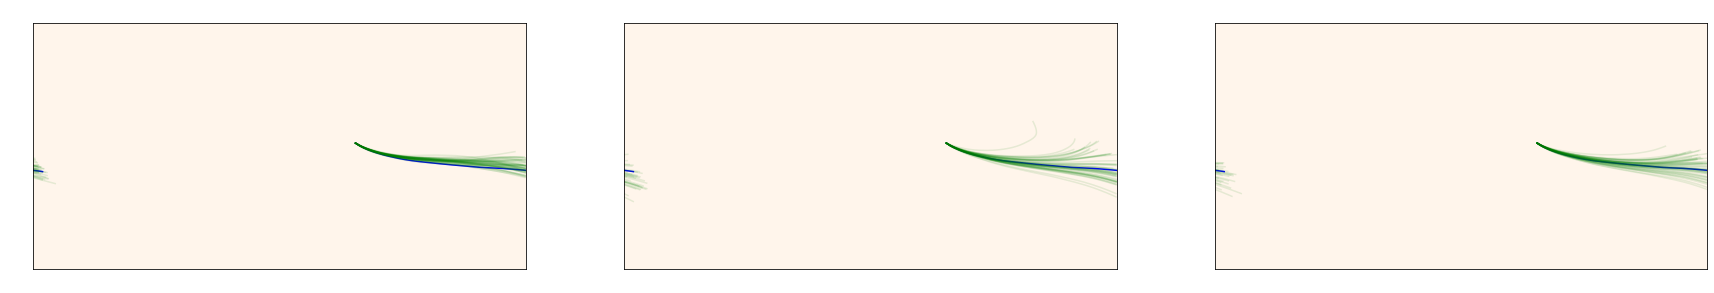

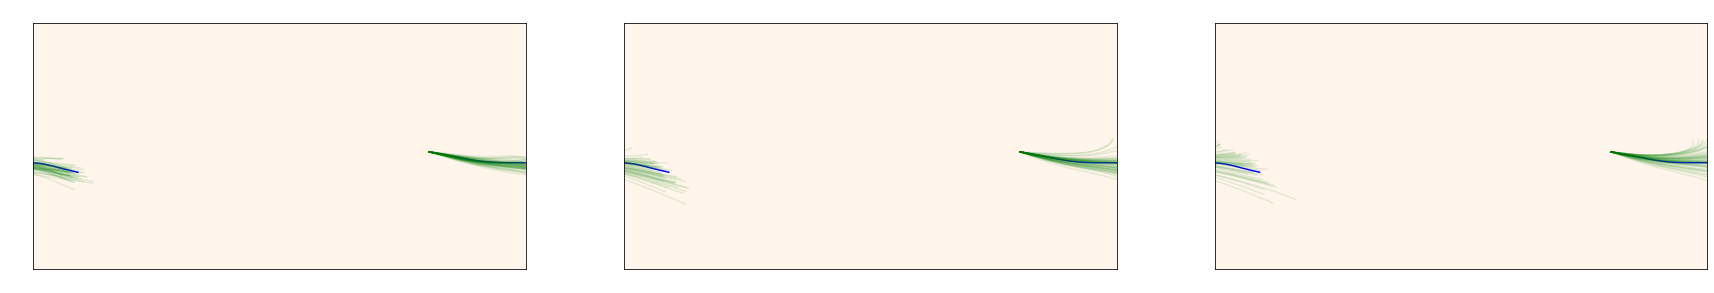

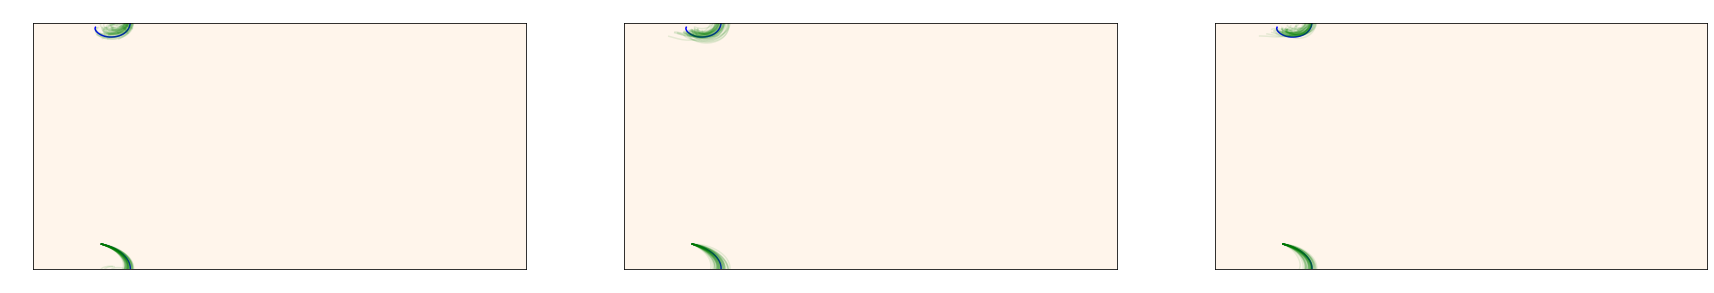

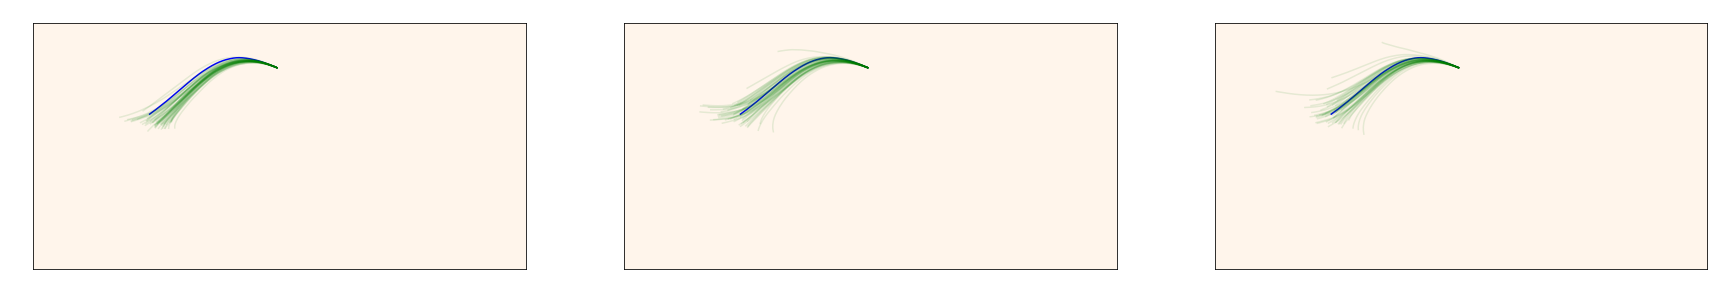

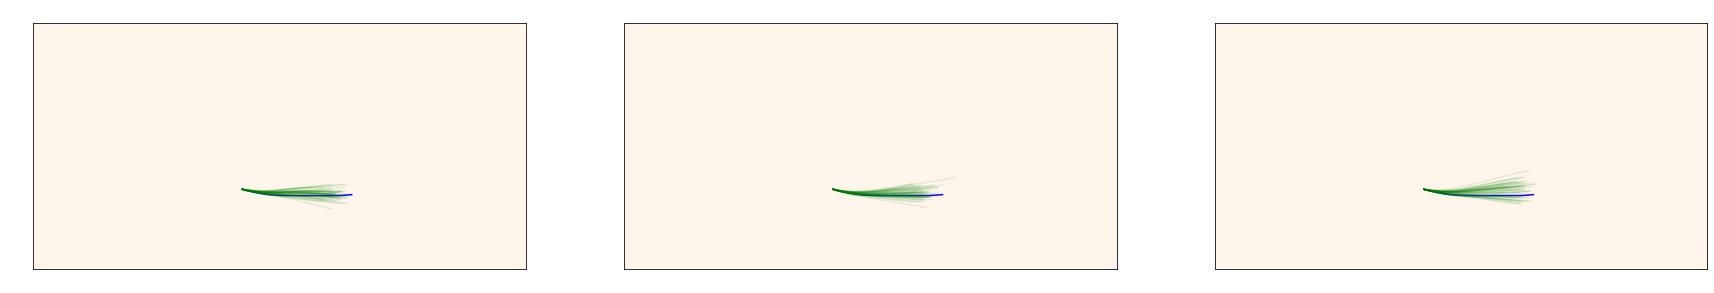

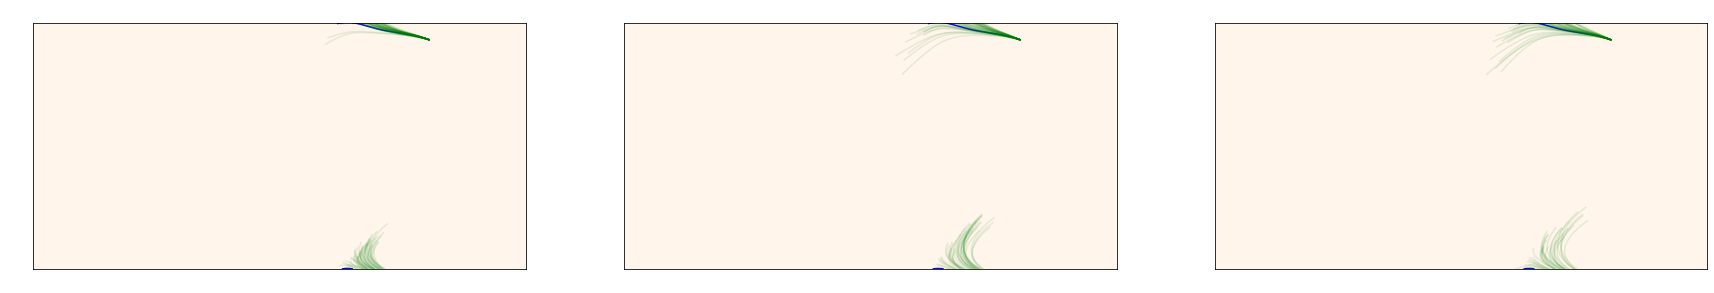

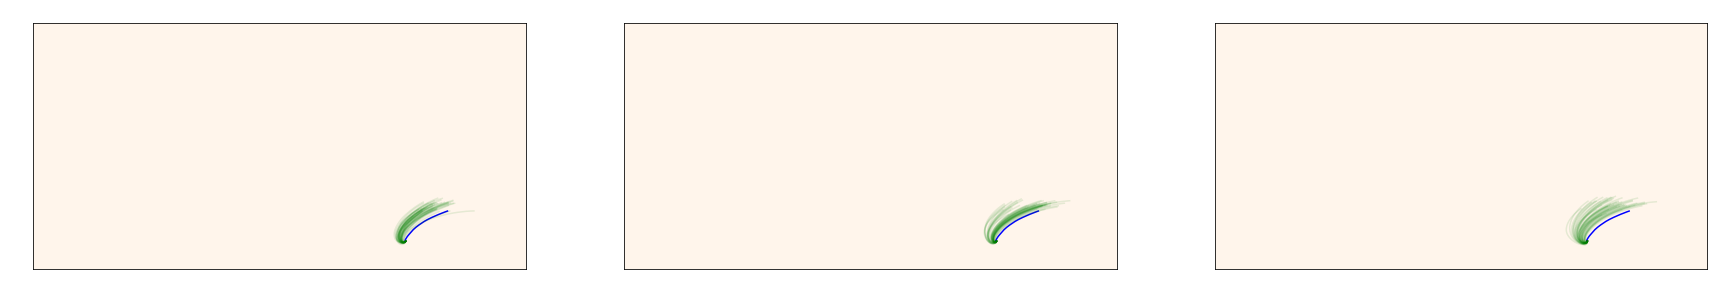

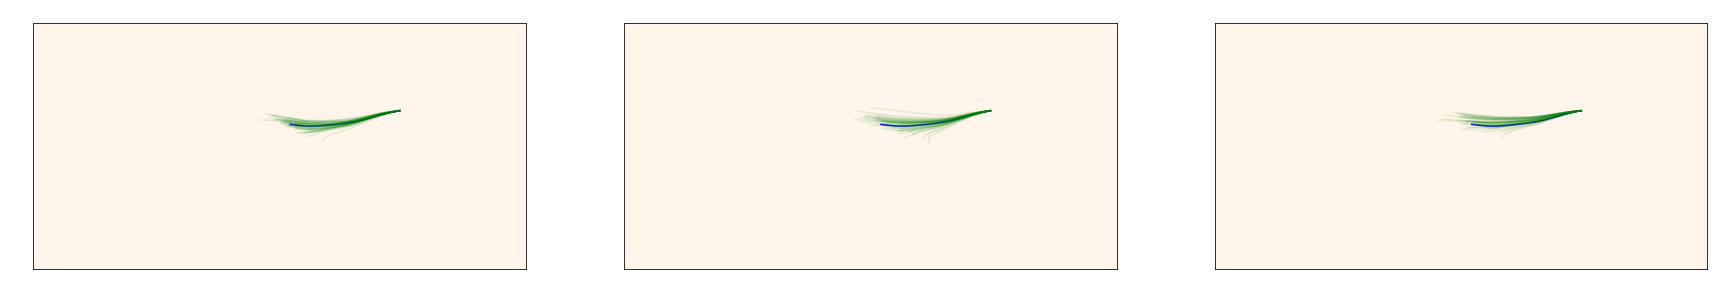

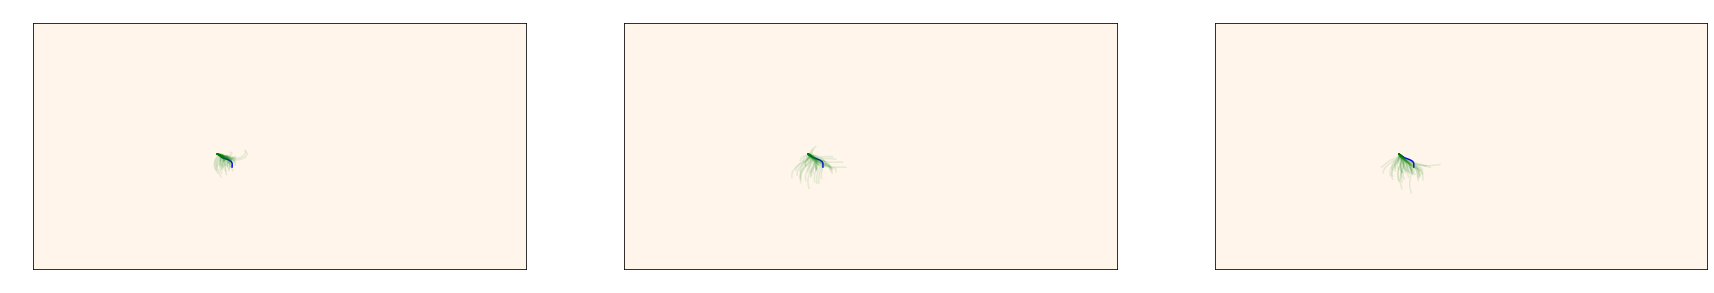

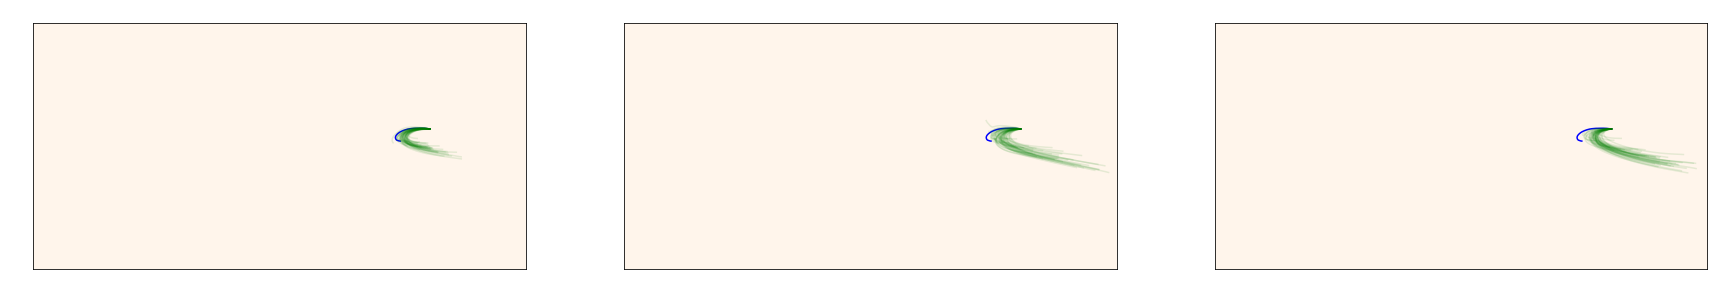

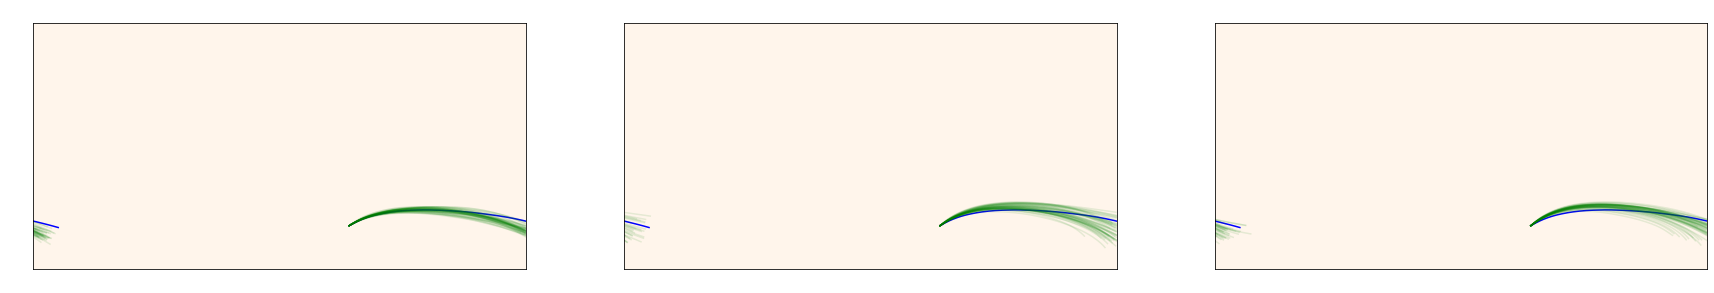

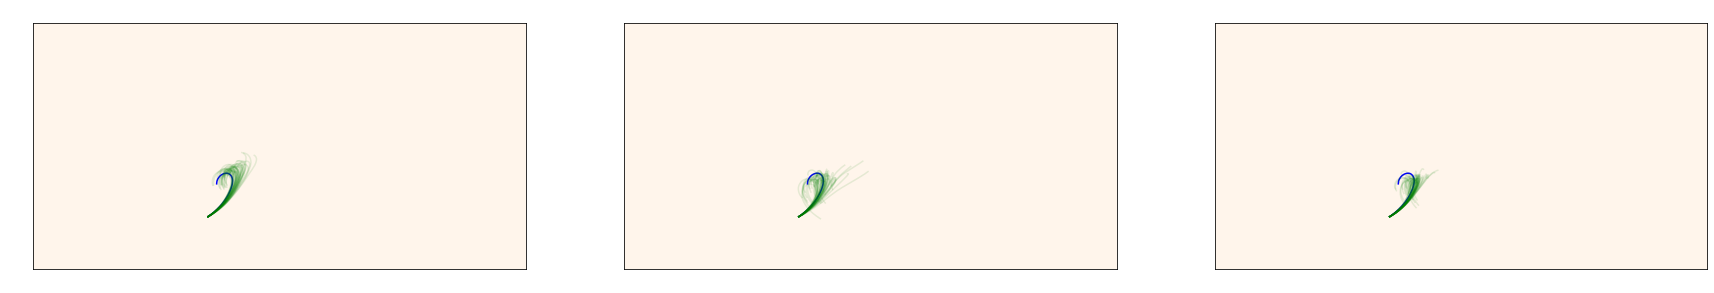

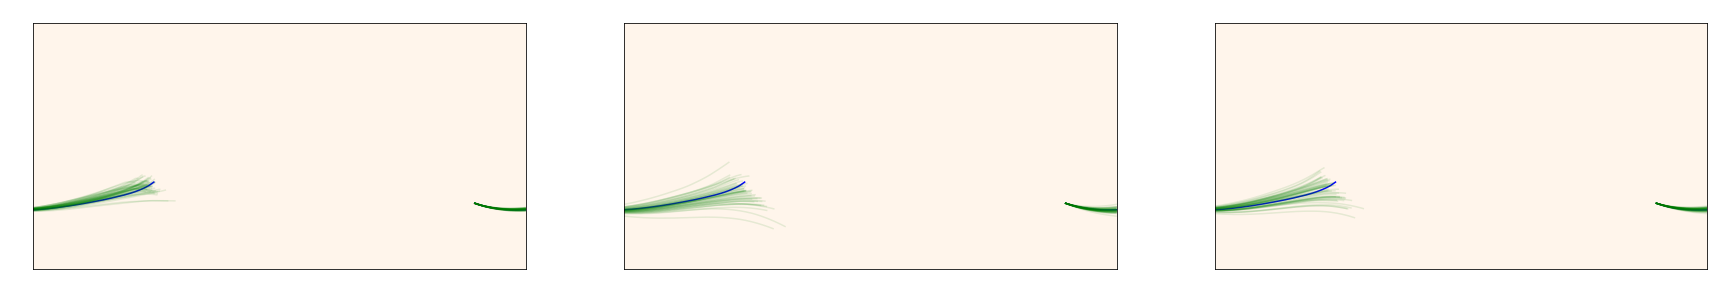

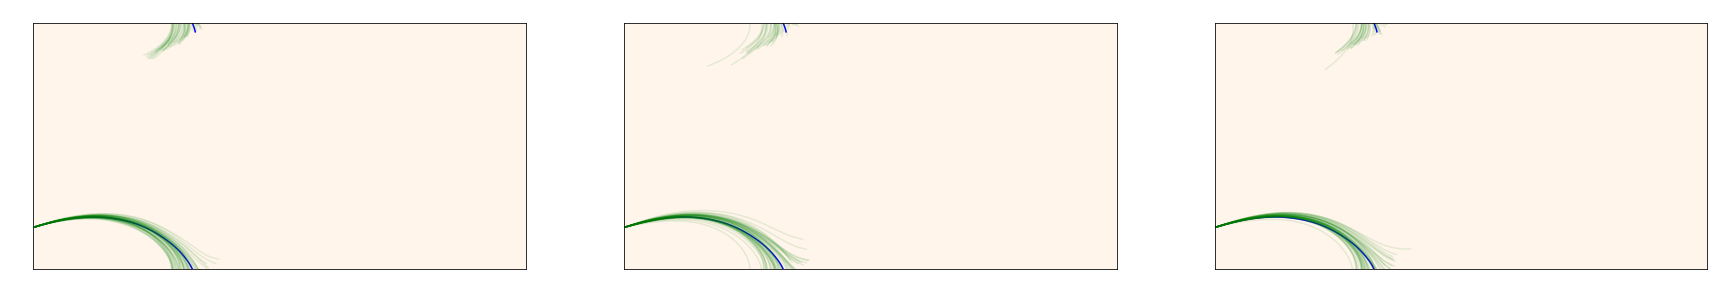

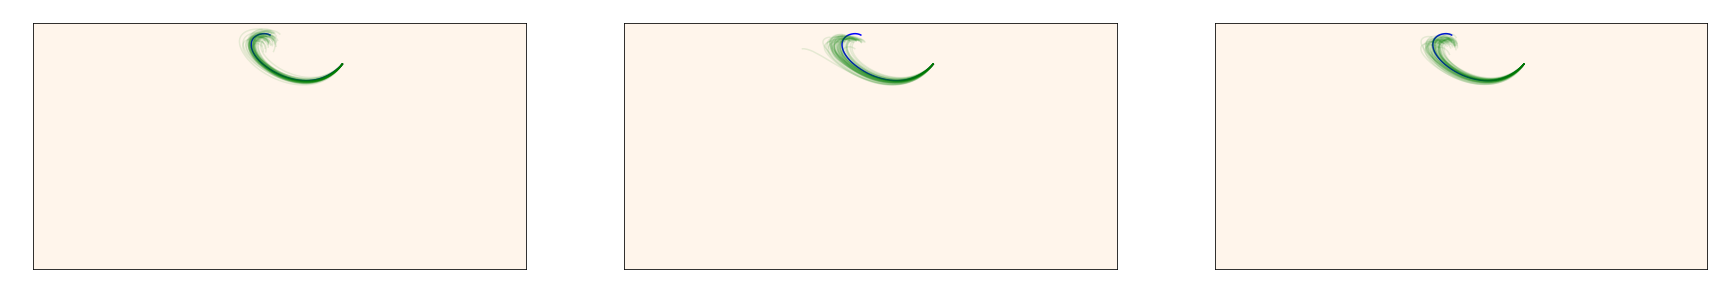

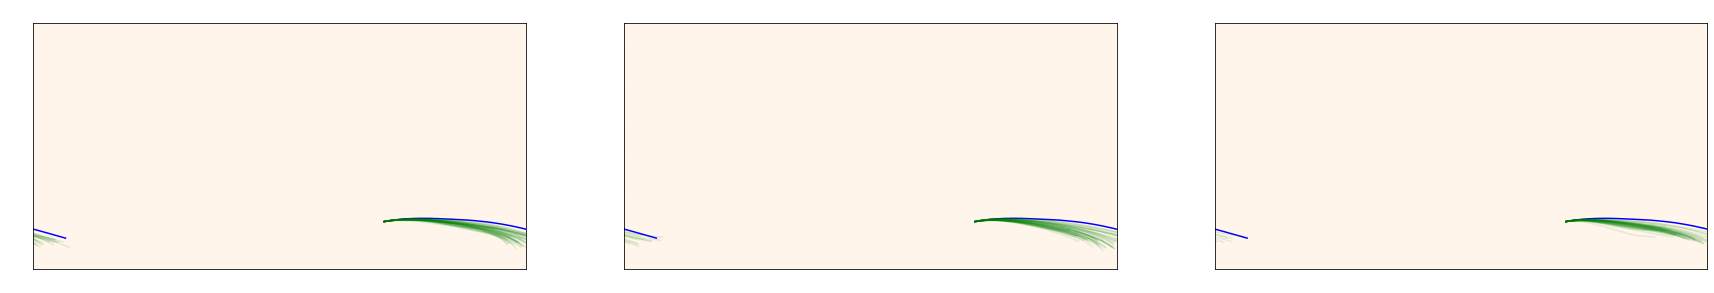

In [15]:
d = 0 #15, 2, 7, 24

for d in range(20):

    fig, axs = plt.subplots(1,3, figsize=(30,10))
    axs[0].set_title("SL EnKF")
    axs[1].set_title("ML EnKF (2 levels)")
    axs[2].set_title("ML EnKF (3 levels)")

    for i in range(len(axs)):
        DrifterPlotHelper.background_from_grid_parameters(doubleJetCase_args["nx"], doubleJetCase_args["ny"], doubleJetCase_args["dx"], doubleJetCase_args["dy"], ax=axs[i])
        DrifterPlotHelper.add_drifter_on_background(axs[i], true_trajectories, drifter_id=d)

    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[0], slda_trajectories, drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[1], mlda_trajectories, drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[2], mlda2_trajectories, drifter_id=d, color='Green', alpha=0.1)

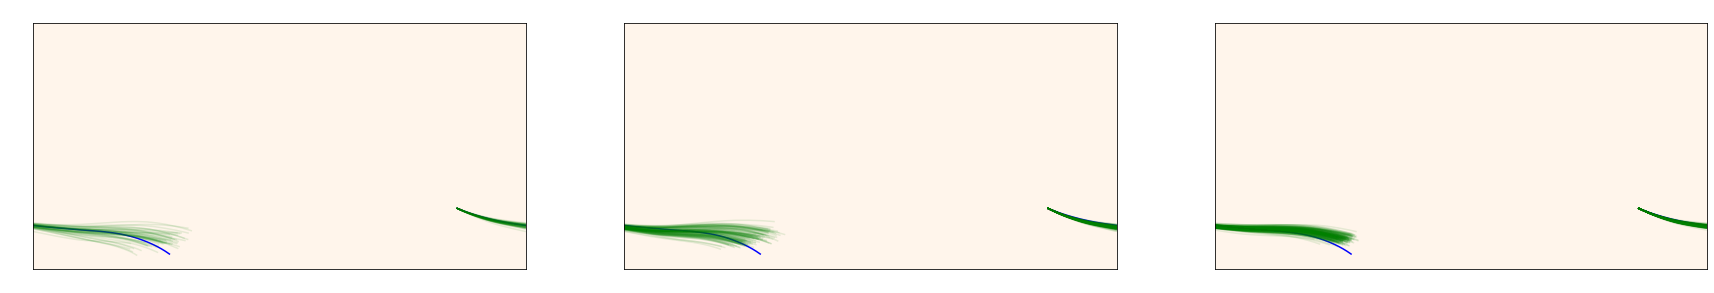

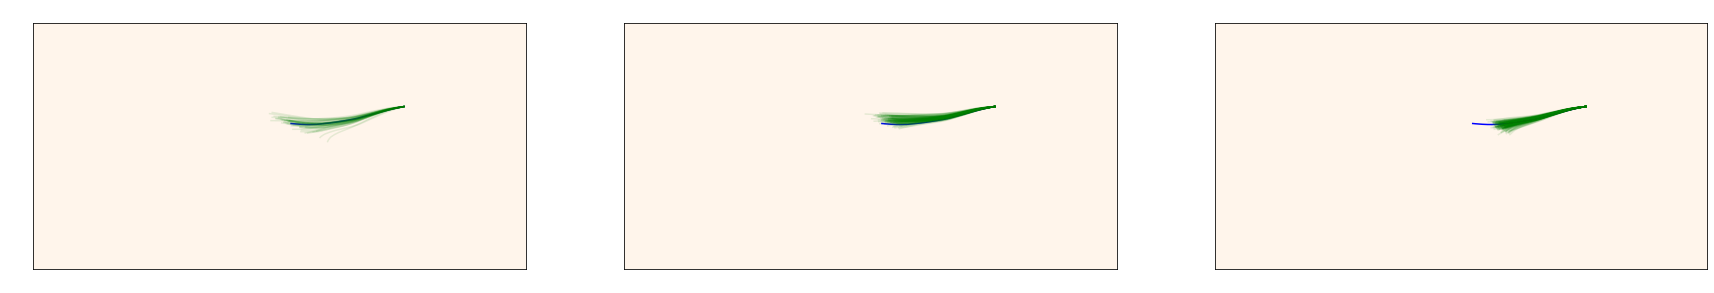

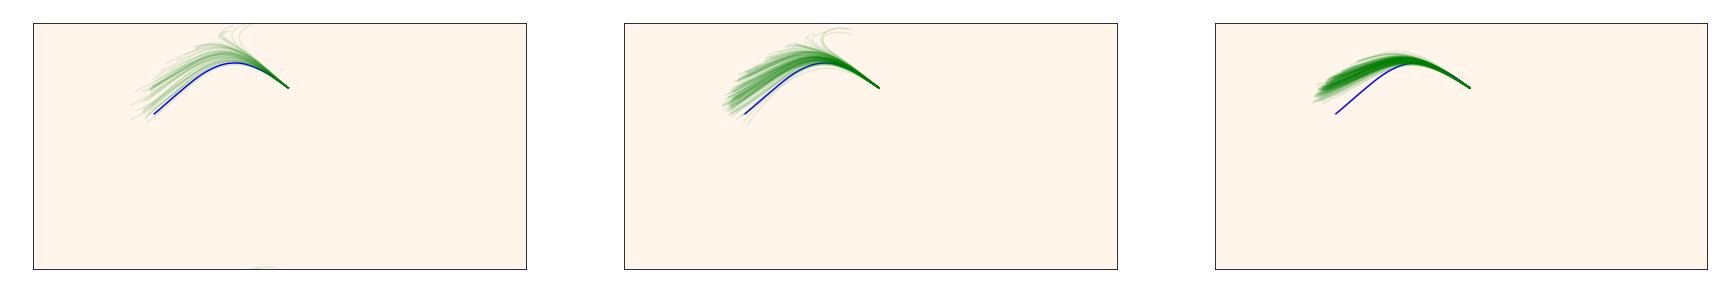

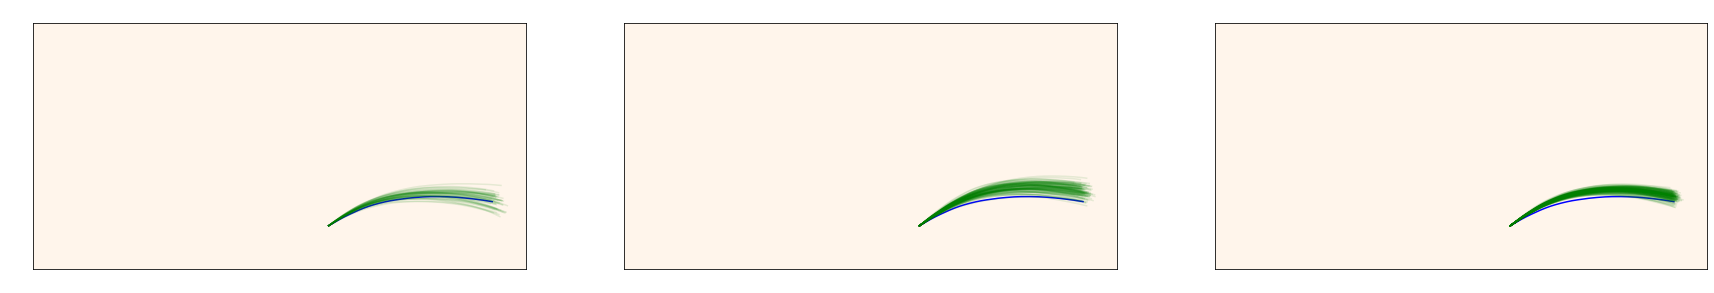

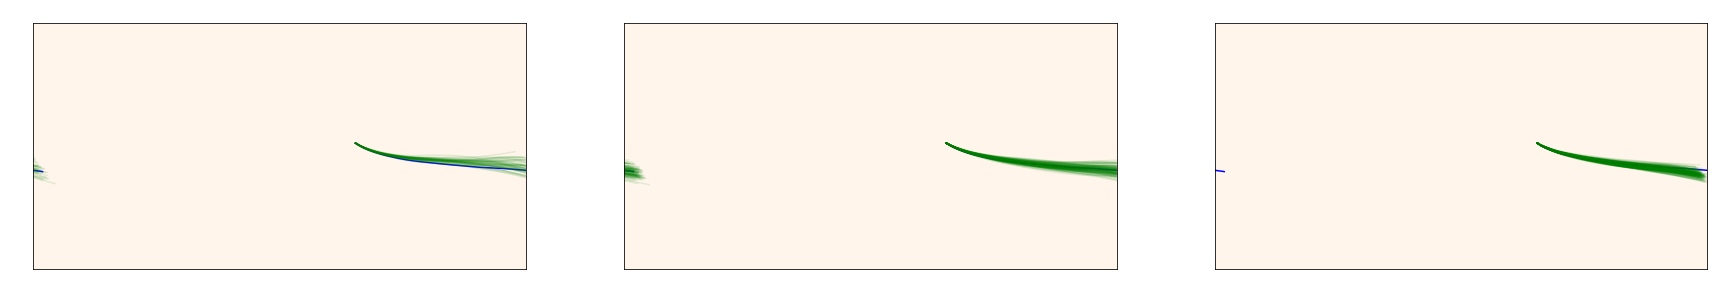

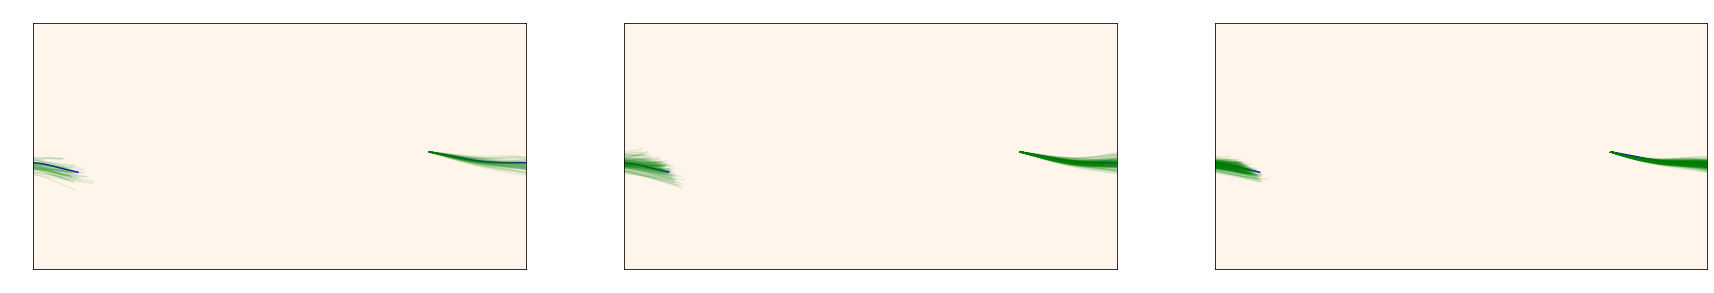

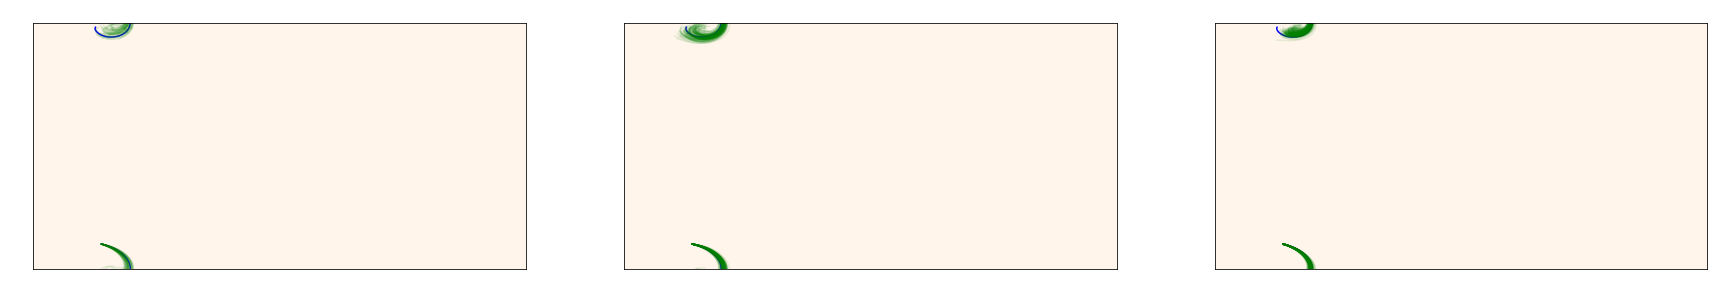

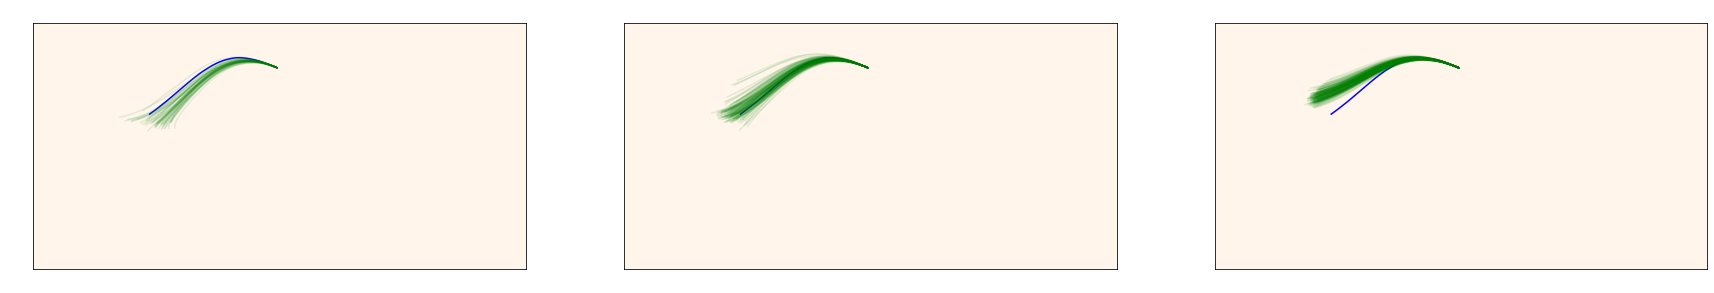

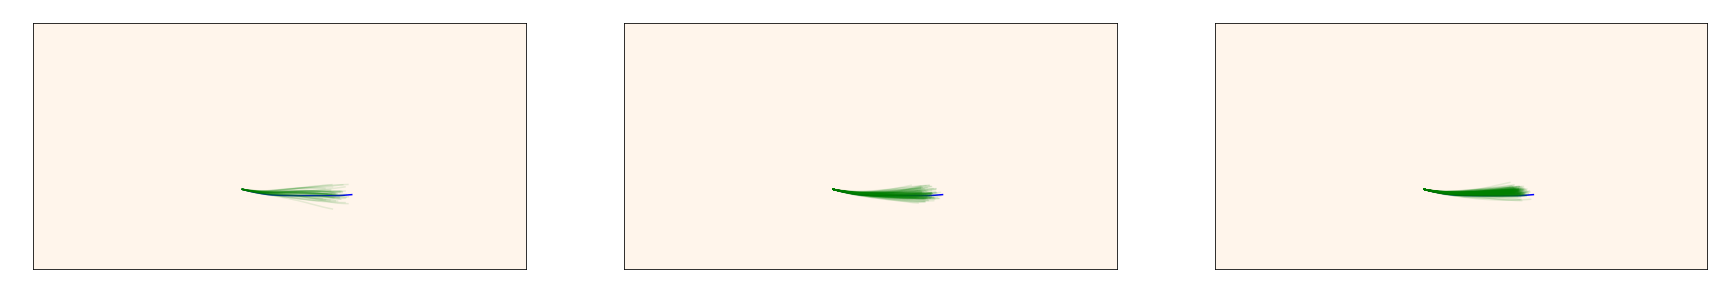

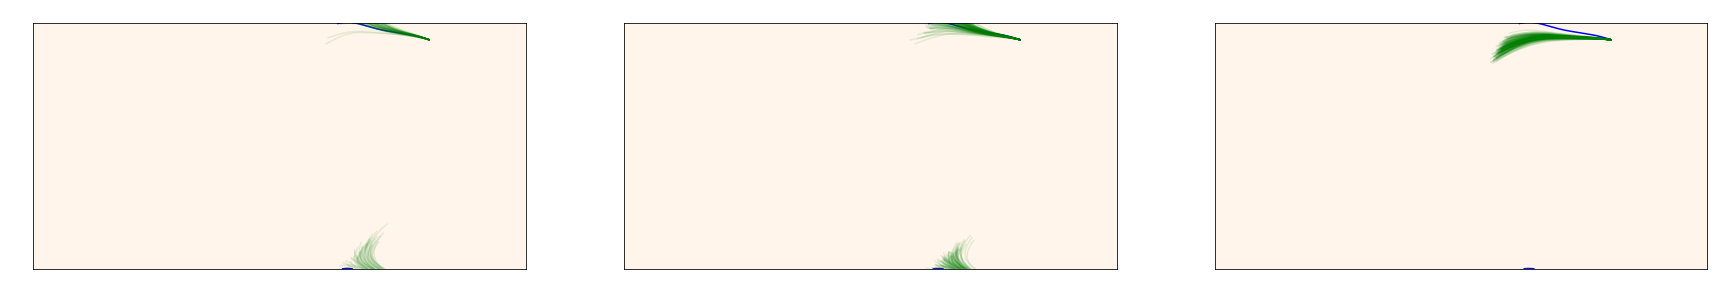

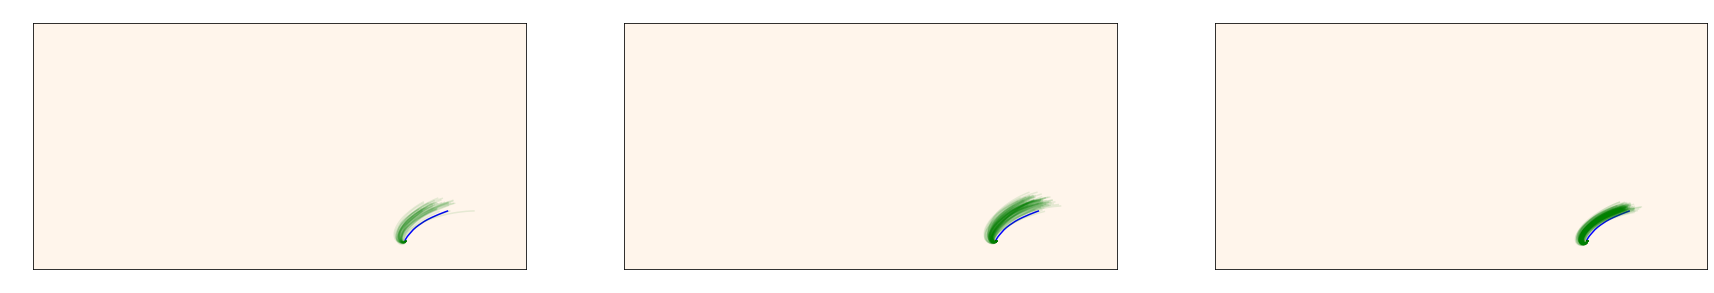

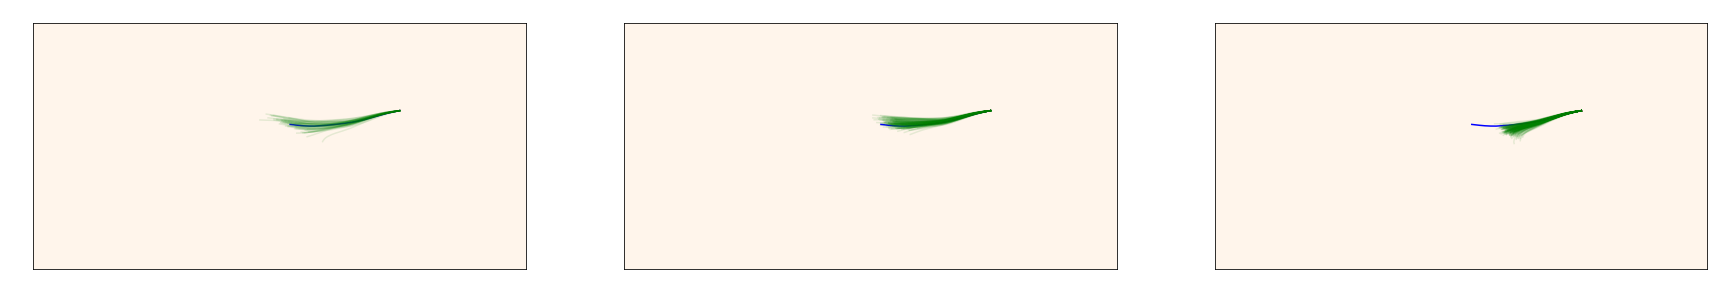

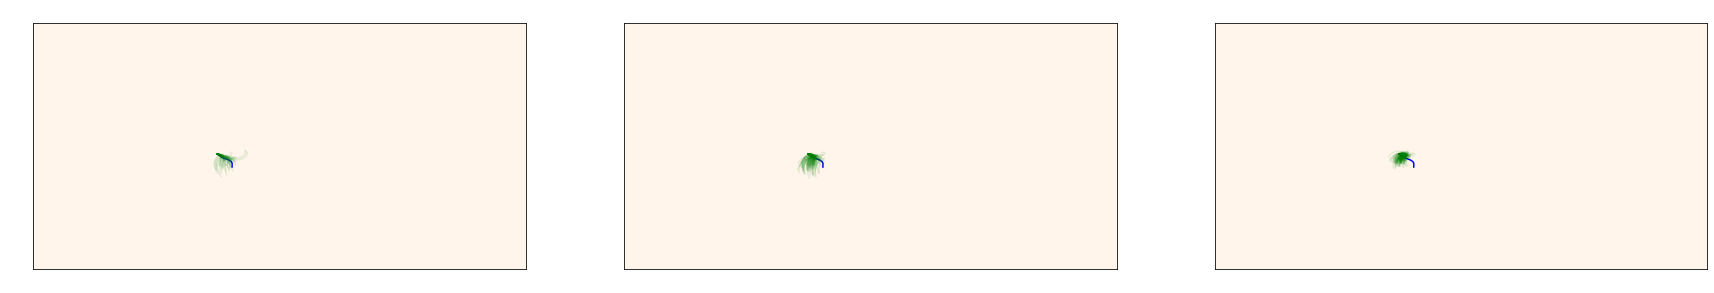

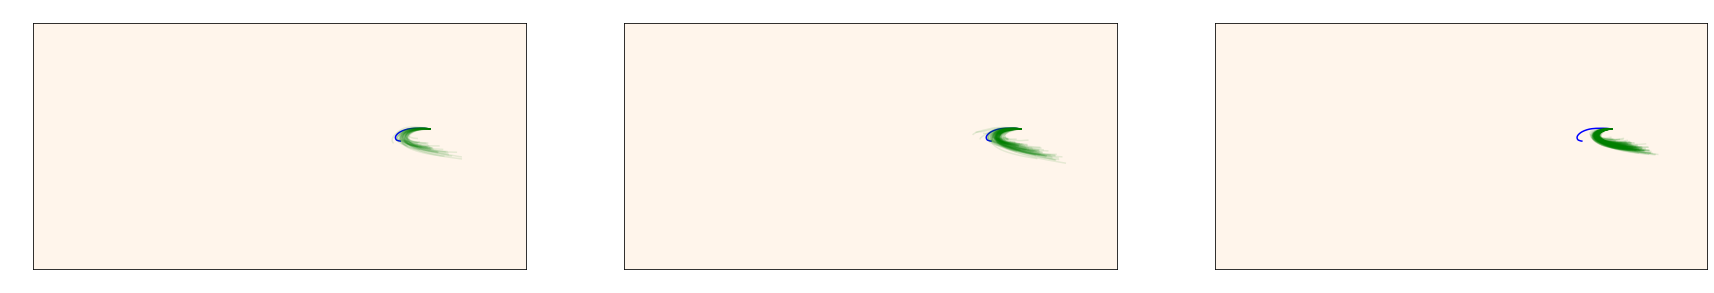

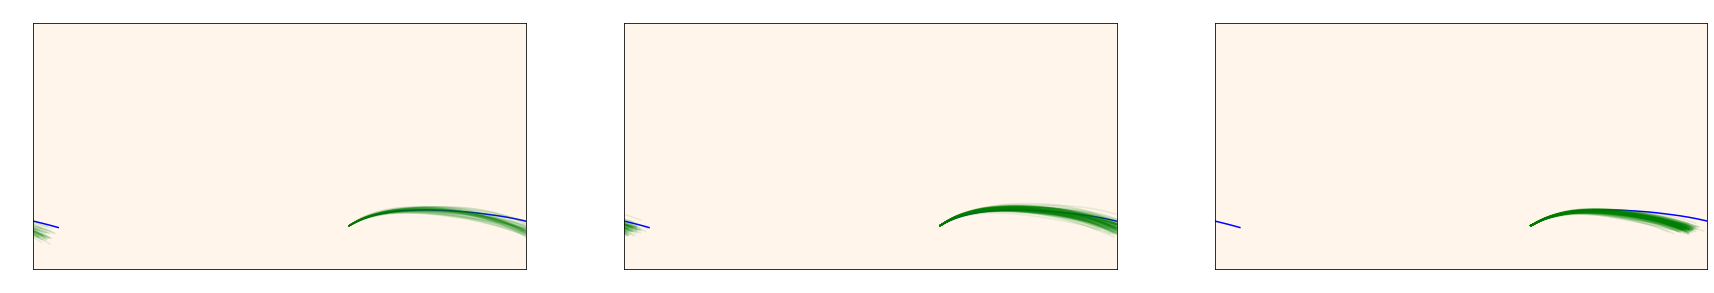

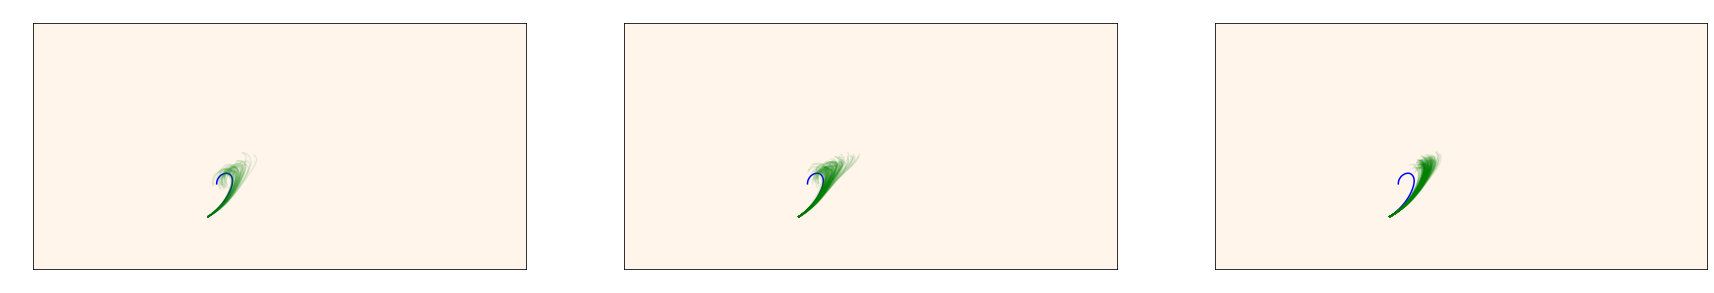

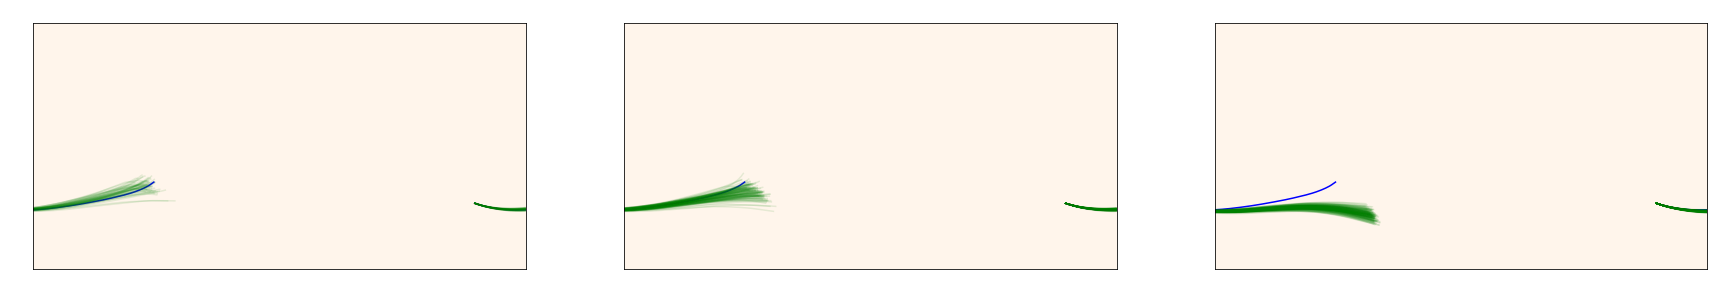

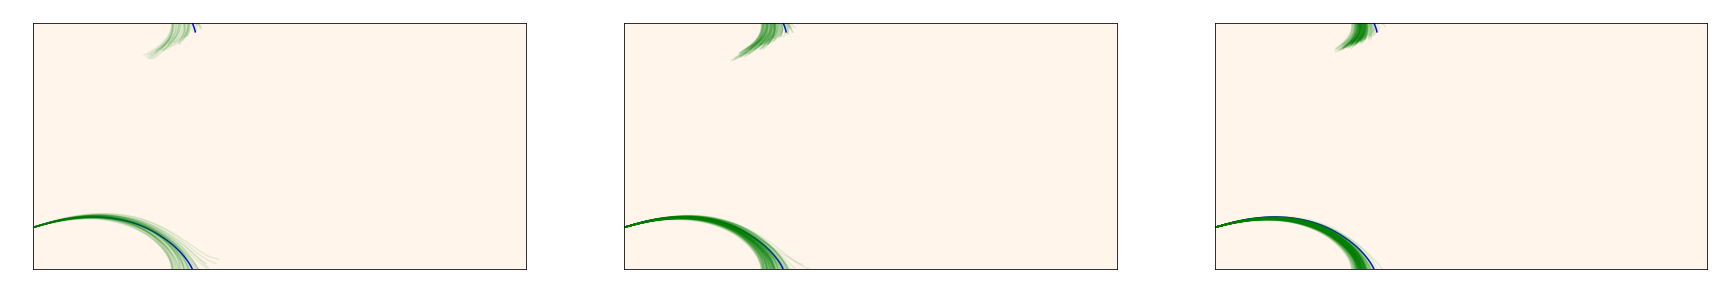

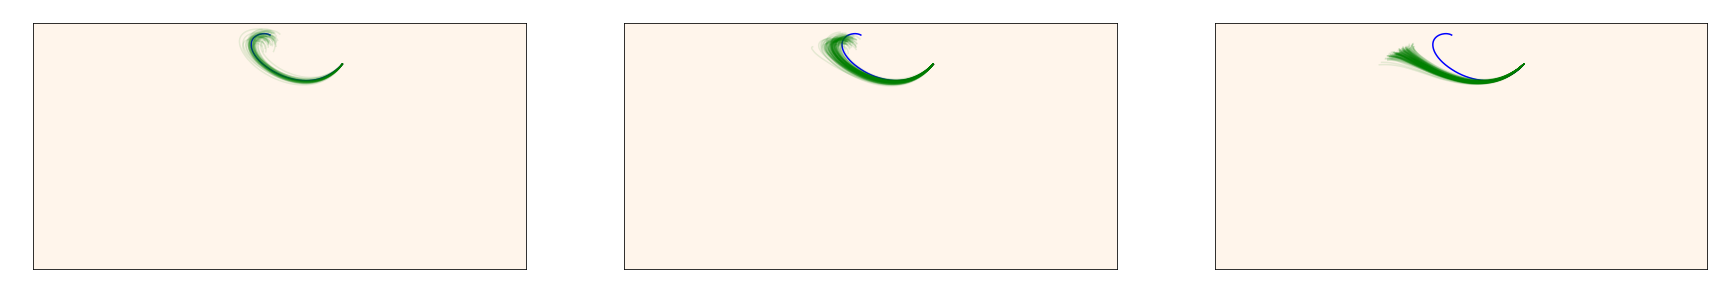

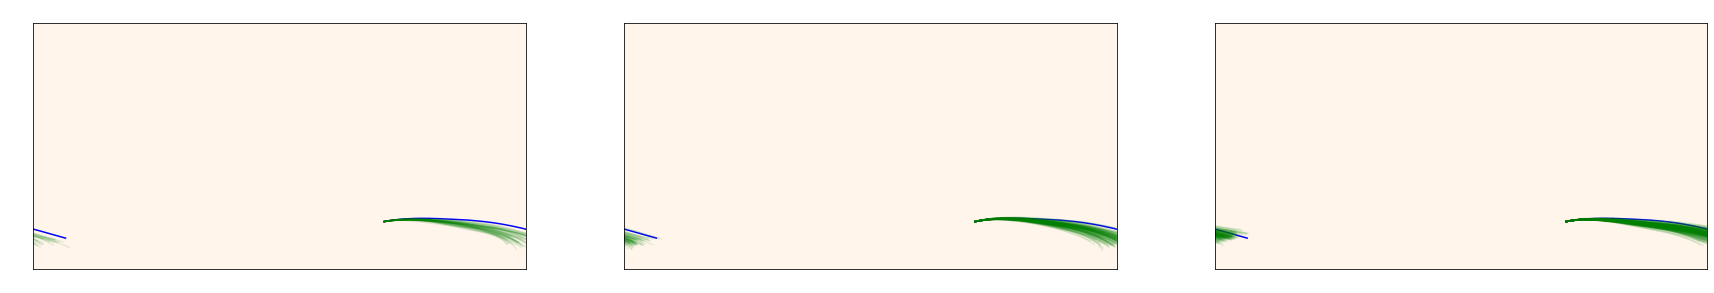

In [16]:
for d in range(20):
    fig, axs = plt.subplots(1,3, figsize=(30,10))
    axs[0].set_title("SL EnKF")
    axs[1].set_title("SL EnKF (1 level below truth)")
    axs[2].set_title("SL EnKF (2 level below truth)")

    for i in range(len(axs)):
        DrifterPlotHelper.background_from_grid_parameters(doubleJetCase_args["nx"], doubleJetCase_args["ny"], doubleJetCase_args["dx"], doubleJetCase_args["dy"], ax=axs[i])
        DrifterPlotHelper.add_drifter_on_background(axs[i], true_trajectories, drifter_id=d)

    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[0], slda_trajectories, drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[1], slda2_trajectories, drifter_id=d, color='Green', alpha=0.1)
    DrifterPlotHelper.add_ensemble_drifter_on_background(axs[2], slda3_trajectories, drifter_id=d, color='Green', alpha=0.1)